In [3]:
%matplotlib inline
from matplotlib.pyplot import *

import os
import sys
import numpy as np
import logging
import multiprocessing
from multiprocessing import Pool
import glob
from astropy.io import fits
# from readmultispec import *
# from continuum import *
################################################################################
#--- iSpec directory -------------------------------------------------------------
# ispec_dir = os.path.dirname(os.path.realpath(__file__)) + "/"
ispec_dir = '/Users/yuan/Documents/iSpec_v20230804/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec


#--- Change LOG level ----------------------------------------------------------
#LOG_LEVEL = "warning"
LOG_LEVEL = "info"
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))
################################################################################


[2024-07-15 09:29:12,108] [INFO] [utils:_init_num_threads:148]: Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2024-07-15 09:29:12,109] [INFO] [utils:_init_num_threads:160]: NumExpr defaulting to 8 threads.


In [4]:
hd_path = '../Spectra/HD2114/'
temp_path = '../Spectra/HD81797/'


In [5]:
files = glob.glob(hd_path+"*.fits", recursive = True)
files.sort()
for i in range(len(files)):
    print (i,files[i])

hd_file = fits.open(files[0])

hd = ispec.read_spectrum(files[0])


0 ../Spectra/HD2114/ADP.2016-09-21T06:44:01.920.fits


In [6]:
hd

rec.array([(3527.22      ,  0.        , nan),
           (3527.25      ,  0.        , nan),
           (3527.28      ,  0.        , nan), ...,
           (9215.99987285, -0.39624506, nan),
           (9216.02987285,  0.        , nan),
           (9216.05987284,  0.        , nan)],
          dtype=[('waveobs', '<f8'), ('flux', '<f8'), ('err', '<f8')])

In [7]:
files = glob.glob(temp_path+"*.fits", recursive = True)
files.sort()
for i in range(len(files)):
    print (i,files[i])

tp_file = fits.open(files[0])

tp = ispec.read_spectrum(files[0])


0 ../Spectra/HD81797/ADP.2016-09-21T06:44:02.576.fits
1 ../Spectra/HD81797/ADP.2016-09-21T06:44:02.578.fits
2 ../Spectra/HD81797/ADP.2016-09-21T06:44:02.580.fits
3 ../Spectra/HD81797/ADP.2016-09-21T06:44:02.582.fits


In [8]:

def plot_spectra(spectra, filename=None, grid = True, title = None, ylabel = 'Flux', xlabel = 'Wavelength (nm)'):
    """
        Plot a spectrum or array of spectra.
        If filename (i.e. plot.png) is specified, then the plot is saved into that file
        and not shown on the screen.
    """
    figure()
    ax1 = subplot(1, 1, 1)

    if grid:
        ax1.grid(True, which="both")

    if title is not None:
        ax1.set_title(title, fontsize="10")

    if xlabel is not None:
        ax1.set_xlabel(xlabel, fontsize="10")

    if ylabel is not None:
        ax1.set_ylabel(ylabel, fontsize="10")

    #~ if filename is not None:
        #~ major_tick = np.round((np.max(spectra['waveobs']) - np.min(spectra['waveobs'])) / 100, decimals=2)
        #~ minor_tick = major_tick / 2
        #~ ax1.xaxis.set_major_locator(MultipleLocator(major_tick))
        #~ ax1.xaxis.set_minor_locator(MultipleLocator(minor_tick))
        #~ ax1.xaxis.set_major_formatter(FormatStrFormatter("%1.2f"))

    colors = ('b', 'g', 'r', 'c', 'm', 'y', 'k')
    linestyles = ['', 'steps', 'steps:', '-', '--', ':']

    if not type(spectra) in [list, np.ndarray]:
        spectra = [spectra]

    color = 0
    for spec in spectra:
        ax1.plot(spec['waveobs'], spec['flux'], lw=1, color=colors[color % 7], linestyle=linestyles[3], marker='', markersize=1, markeredgewidth=0, markerfacecolor=colors[0])
        color = (color + 1) % len(colors)

    if filename is None:
        show()
    else:
        if filename[-4:] == ".png":
            savefig(filename)
        else:
            savefig(filename+".png")

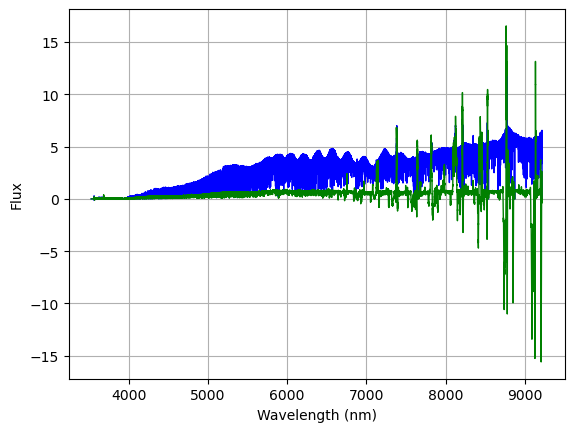

In [9]:
plot_spectra([tp, hd])

In [10]:
def create_spectrum_structure(waveobs, flux=None, err=None):
    """
    Create spectrum structure
    """
    spectrum = np.recarray((len(waveobs), ), dtype=[('waveobs', float),('flux', float),('err', float)])
    spectrum['waveobs'] = waveobs

    if flux is not None:
        spectrum['flux'] = flux
    else:
        spectrum['flux'] = 0.0

    if err is not None:
        spectrum['err'] = err
    else:
        spectrum['err'] = 0.0

    return spectrum

In [11]:
hd1 = create_spectrum_structure(hd['waveobs']*.1, flux=hd['flux'], err=None)
tp1 = create_spectrum_structure(tp['waveobs']*.1, flux=tp['flux'], err=None)


In [12]:
def cut_spectrum_from_range(spec, wave_base, wave_top):
    # star_spectrum = ispec.read_spectrum(file)
    #--- Cut -----------------------------------------------------------------------
    logging.info("Cutting...")

    # - Keep points between two given wavelengths
    wfilter = ispec.create_wavelength_filter(spec, wave_base=wave_base, wave_top=wave_top)
    cutted_star_spectrum = spec[wfilter]
    
    return cutted_star_spectrum
    # logging.info("Saving spectrum...")
    

In [13]:
hd_r = cut_spectrum_from_range(hd1, 400, 500)
tp_r = cut_spectrum_from_range(tp1, 400, 500)


[2024-07-15 09:29:24,650] [INFO] [643192519:cut_spectrum_from_range:4]: Cutting...
[2024-07-15 09:29:24,654] [INFO] [643192519:cut_spectrum_from_range:4]: Cutting...


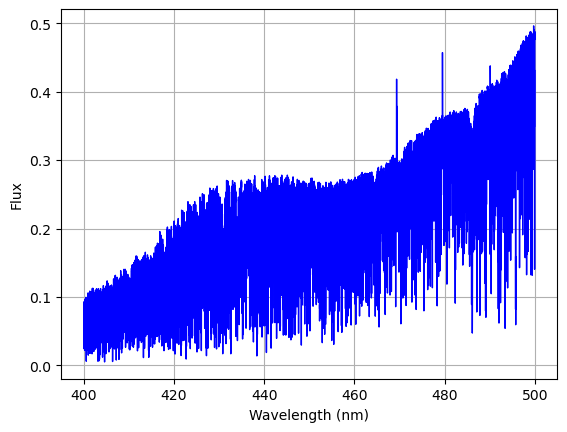

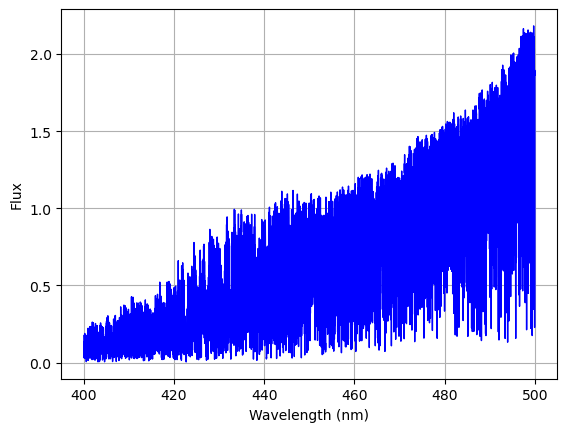

In [14]:
plot_spectra([hd_r])
plot_spectra([tp_r])

In [15]:
def create_filter_cosmic_rays(spectrum, continuum_model, resampling_wave_step=0.001, window_size=15, variation_limit=0.01, continuum_limit=1.0):
    """
    It uses a median filter to smooth out single-measurement deviations. Then it uses
    sigma-clipping to remove large variations between the actual and smoothed image.

    For doing the comparison, the original spectrum should be resampled to have
    homonenous wave step.

    Only those detected cosmics above the continuum will be discarded.
    """
    import scipy.signal
    wavelengths = np.arange(np.min(spectrum['waveobs']), np.max(spectrum['waveobs'])+resampling_wave_step, resampling_wave_step)
    resampled_spectrum = ispec.resample_spectrum(spectrum, wavelengths)

    resampled_smooth = create_spectrum_structure(resampled_spectrum['waveobs'])
    resampled_smooth['flux'] = scipy.signal.medfilt(resampled_spectrum['flux'], window_size)
    smooth = ispec.resample_spectrum(resampled_smooth, spectrum['waveobs'])

    cosmics = (spectrum['flux'] - smooth['flux'])/ continuum_model(spectrum['waveobs']) > variation_limit
    cosmics = np.logical_and(cosmics, (spectrum['flux']/ continuum_model(spectrum['waveobs'])) > continuum_limit)
    return smooth, cosmics

In [16]:
def filter_cosmic_rays(spec, res, variation_limit=.6, continuum_limit=1.5):
    # star_spectrum = ispec.read_spectrum(file)
    star_spectrum = spec

    #--- Continuum fit -------------------------------------------------------------
    model = "Splines" # "Polynomy"
    degree = 2
    nknots = None # Automatic: 1 spline every 5 nm
    from_resolution = res

    # Strategy: Filter first median values and secondly MAXIMUMs in order to find the continuum
    order='median+max'
    median_wave_range=0.05*2.
    max_wave_range=1.0*2.

    star_continuum_model = ispec.fit_continuum(star_spectrum, from_resolution=from_resolution, \
                                nknots=nknots, degree=degree, \
                                median_wave_range=median_wave_range, \
                                max_wave_range=max_wave_range, \
                                model=model, order=order, \
                                automatic_strong_line_detection=True, \
                                strong_line_probability=0.2, \
                                use_errors_for_fitting=True)
    #--- Filtering cosmic rays -----------------------------------------------------
    # Spectrum should be already normalized
    resampling_wave_step = (spec[-1][0]-spec[0][0])/r1 * 2
    window_size = 15

    smooth, cosmics = create_filter_cosmic_rays(star_spectrum, star_continuum_model, \
                                            resampling_wave_step=resampling_wave_step, window_size=window_size, \
                                            variation_limit=variation_limit, continuum_limit=continuum_limit)
    clean_star_spectrum = star_spectrum[~cosmics]

    cont_star_spectrum = create_spectrum_structure(star_spectrum['waveobs'])
    cont_star_spectrum['flux'] = star_continuum_model(star_spectrum['waveobs'])
    
    return cont_star_spectrum, smooth, cosmics, clean_star_spectrum

In [47]:
r1 = np.int64((hd[-1][0]-hd[0][0])/(hd[1][0]-hd[0][0]))
print (r1)



189628


In [48]:
continuum_limit = 1.25
variation_limit = 0.1
hd_cont, hd_s, cosmics_hd, hd_c = filter_cosmic_rays(hd_r, r1, variation_limit, continuum_limit)


[2024-07-15 09:46:40,757] [INFO] [continuum:__fit_continuum:637]: Resampling spectrum to wave_step: 0.00211 nm (R = 189628)
[2024-07-15 09:46:41,028] [INFO] [continuum:__median_filter:307]: Median filter with step: 47
[2024-07-15 09:46:41,043] [INFO] [continuum:__max_filter:298]: Max filter with step: 949


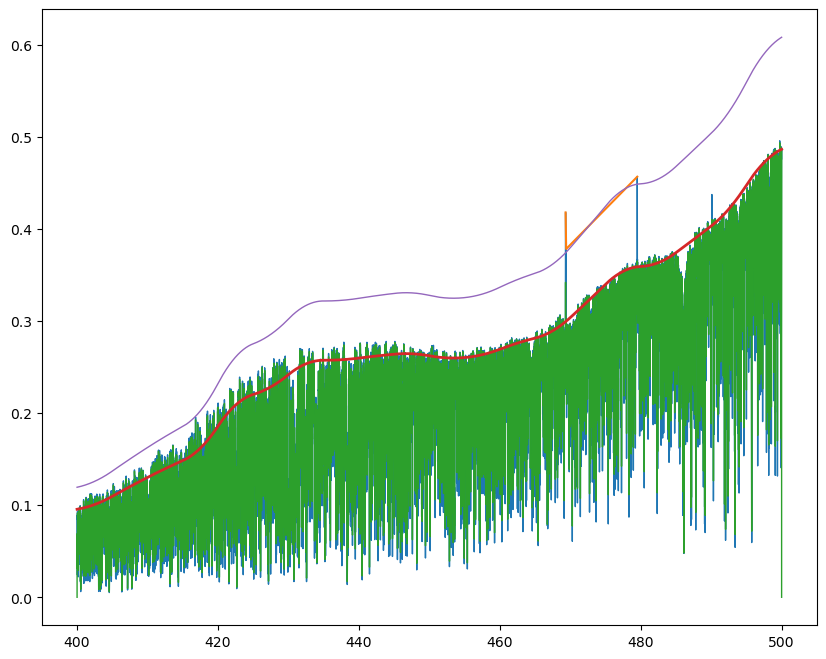

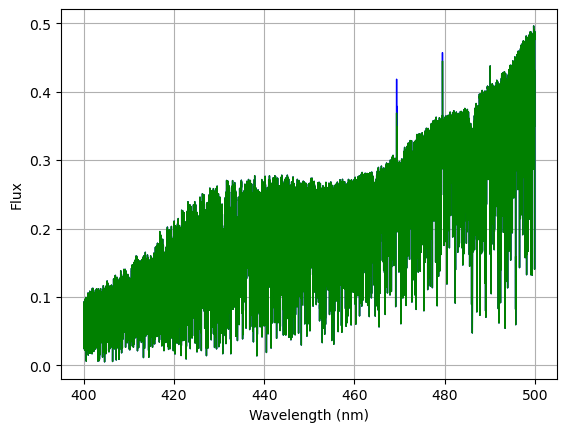

In [49]:
figure(figsize=(10,8))
plot(hd_r['waveobs'], hd_r['flux'], lw=1)

plot(hd_r['waveobs'][cosmics_hd], hd_r['flux'][cosmics_hd])

plot(hd_s['waveobs'], hd_s['flux'], lw=1)
plot(hd_cont['waveobs'], hd_cont['flux'], lw=2)
plot(hd_cont['waveobs'], continuum_limit*hd_cont['flux'], lw=1)


plot_spectra([hd_r, hd_c])


In [50]:
def normalize_whole_spectrum(spec, res):
    """
    Use the whole spectrum, strategy 'median+max'
    """
    star_spectrum = spec

    #--- Continuum fit -------------------------------------------------------------
    model = "Splines" # "Polynomy"
    degree = 2
    nknots = None # Automatic: 1 spline every 5 nm
    from_resolution = res

    # Strategy: Filter first median values and secondly MAXIMUMs in order to find the continuum
    order='median+max'
    median_wave_range=0.05*2
    max_wave_range=1.0*2

    star_continuum_model = ispec.fit_continuum(star_spectrum, from_resolution=from_resolution, \
                                nknots=nknots, degree=degree, \
                                median_wave_range=median_wave_range, \
                                max_wave_range=max_wave_range, \
                                model=model, order=order, \
                                automatic_strong_line_detection=True, \
                                strong_line_probability=0.5, \
                                use_errors_for_fitting=True)

    #--- Continuum normalization ---------------------------------------------------
    logging.info("Continuum normalization...")
    normalized_star_spectrum = ispec.normalize_spectrum(star_spectrum, star_continuum_model, consider_continuum_errors=False)
    # Use a fixed value because the spectrum is already normalized
    star_continuum_model = ispec.fit_continuum(star_spectrum, fixed_value=1.0, model="Fixed value")
    cont_star_spectrum = create_spectrum_structure(star_spectrum['waveobs'])
    cont_star_spectrum['flux'] = star_continuum_model(star_spectrum['waveobs'])
  
    return normalized_star_spectrum

In [51]:
hd_n = normalize_whole_spectrum(hd_c, r1)
tp_n = normalize_whole_spectrum(tp_r, r1)


[2024-07-15 09:46:42,270] [INFO] [continuum:__fit_continuum:637]: Resampling spectrum to wave_step: 0.00211 nm (R = 189628)
[2024-07-15 09:46:42,521] [INFO] [continuum:__median_filter:307]: Median filter with step: 47
[2024-07-15 09:46:42,536] [INFO] [continuum:__max_filter:298]: Max filter with step: 949
[2024-07-15 09:46:42,957] [INFO] [1845456760:normalize_whole_spectrum:28]: Continuum normalization...
[2024-07-15 09:46:42,960] [INFO] [continuum:__fit_continuum:637]: Resampling spectrum to wave_step: 0.00211 nm (R = 189628)
[2024-07-15 09:46:43,193] [INFO] [continuum:__median_filter:307]: Median filter with step: 47
[2024-07-15 09:46:43,208] [INFO] [continuum:__max_filter:298]: Max filter with step: 949
[2024-07-15 09:46:43,630] [INFO] [1845456760:normalize_whole_spectrum:28]: Continuum normalization...


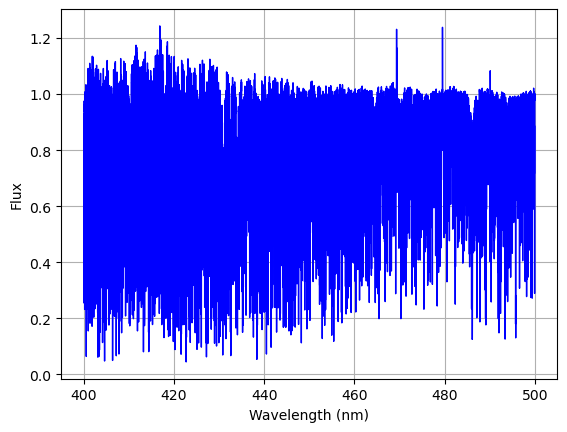

In [52]:
plot_spectra([hd_n])


In [53]:
def determine_radial_velocity_with_template(star, temp):
    # mu_cas_spectrum = ispec.read_spectrum(file)
    mu_cas_spectrum = star

    #--- Radial Velocity determination with template -------------------------------
    logging.info("Radial velocity determination with template...")
    # - Read synthetic template
    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Atlas.Arcturus.372_926nm/template.txt.gz")
    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Atlas.Sun.372_926nm/template.txt.gz")
    # template = ispec.read_spectrum(temp)
    template = temp

    #template = ispec.read_spectrum(ispec_dir + "/input/spectra/templates/Synth.Sun.300_1100nm/template.txt.gz")

    models, ccf = ispec.cross_correlate_with_template(mu_cas_spectrum, template, \
                            lower_velocity_limit=-100, upper_velocity_limit=100, \
                            velocity_step=0.1, fourier=False)

    # Number of models represent the number of components
    components = len(models)
    # First component:
    rv = np.round(models[0].mu(), 2) # km/s
    rv_err = np.round(models[0].emu(), 2) # km/s

    return ccf, rv, rv_err


In [54]:
ccf1, rv_rel1, rv_err1 = determine_radial_velocity_with_template(hd_n, tp_n)


[2024-07-15 09:46:46,749] [INFO] [3795685159:determine_radial_velocity_with_template:6]: Radial velocity determination with template...
[2024-07-15 09:46:46,790] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 0.00%
[2024-07-15 09:46:47,002] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 10.04%
[2024-07-15 09:46:47,200] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 20.09%
[2024-07-15 09:46:47,399] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 30.13%
[2024-07-15 09:46:47,600] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 40.18%
[2024-07-15 09:46:47,811] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 50.22%
[2024-07-15 09:46:48,008] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 60.27%
[2024-07-15 09:46:48,204] [INFO] [lines:__cross_correlation_function_uniform_in_velocity:1994]: 70.31%
[2024-07-15 09:46:48,402] [INFO] [lines:_

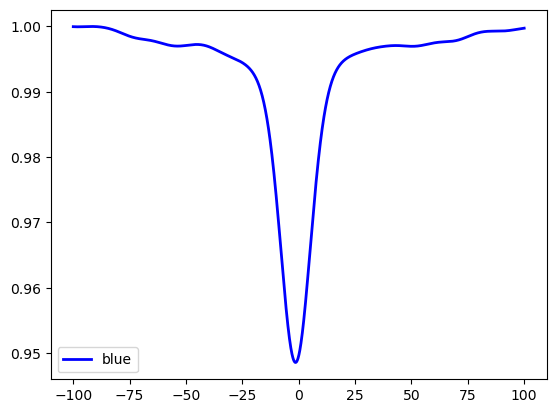

In [55]:

figure()
plot(ccf1['x'], ccf1['y'], label="blue", color='blue', lw=2)
# plot(ccf2['x'], ccf2['y'], label="green", color='green', lw=2)
# plot(ccf3['x'], ccf3['y'], label="red", color='red', lw=2)
legend()

In [33]:
rv_bary_tp = tp_file[0].header['HIERARCH ESO DRS BARYCORR']
rv_bary_hd = hd_file[0].header['HIERARCH ESO DRS BARYCORR']

print (rv_bary_tp, rv_bary_hd)

27.5679 -24.4935


In [34]:
rv_tp = -4.6

rv1 = rv_rel1 + rv_tp  

# + rv_bary_hd - rv_bary_tp

print (rv1)

-6.029999999999999


In [24]:
ff = fits.open(files[2])
ff[0].header

SIMPLE  =                    T / Written by IDL:  Mon Sep 19 22:09:01 2016      
BITPIX  =                    8                                                  
NAXIS   =                    0                                                  
EXTEND  =                    T / File contains extensions                       
DATASUM = '         0'         / data unit checksum updated 2016-09-19T22:09:04 
ORIGIN  = 'ESO-LASILLA'        / Origin                                         
FILENAME= 'f14691.bdf'         / Original file base-name                        
OBJECT  = 'HD-81797'           / Object                                         
RA      =           141.874931 / [deg] Right ascension                          
DEC     =             -8.66074 / [deg] Declination                              
EQUINOX =               2000.0 / Equinox                                        
DATE-OBS= '2004-11-29T08:15:39.764' / Start of observation                      
MJD-OBS =       53338.344210

In [37]:
hd_n['waveobs'][0]

400.0019989432096

In [40]:
(921.7619872824 - 352.7850000000)/(hd_n['waveobs'][1]-hd_n['waveobs'][0])

189658.99999857153